## Traffic Lights Tracker + Detection ##

### OpenCV ###

This algorithm attempts to identify traffic lights color assuming there's some movement on static cameras based on climatic conditions. In order to do that, it applies a combination of a MOSSE tracker, with a freehand rectangle.

**Why this combination?**

Because under certain conditions, like light changes caused by day-night cycles, the MOSSE tracker may lose the traffic lights because the edges of the object may become blurry or even unexistant. 

This problem can be solved by applying a bigger region of interest for the tracker, which can be immune to light changes do to its content. But this implies adding a drawback: Tracking the exact color of the traffic light on a way bigger region. 

To solve the second question, we'll draw a second ROI manually, inside the already chosen one for the MOSSE tracker, starting from the top left corner (that's just a personal choice).

### Import main modules ###

Pretty much all we'll need is OpenCV and Numpy.

In [2]:
# Install opencv
!pip install opencv-contrib-python

In [5]:
import cv2
print("OpenCV version:", cv2.__version__)
import numpy as np
from IPython.display import Image, display, clear_output

OpenCV version: 4.8.0


### Inference functions ###

In [3]:
def predict_color(frame):
    
    color_found = 'undefined'
    
    # Color thresholds.

    color_list = [
        ['Red', [0, 120, 70], [10, 255, 255]],
        ['Yellow', [12, 55, 80], [32, 255, 255]],
        ['Green / Off', [50, 5, 150], [86, 250, 250]],
        ['Red', [170, 120, 70], [180, 255, 255]]
    ]
    
        
    # Change to HSV spectrum.
    
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # The state of the light is the one with the greatest number of white pixels.
        
    max_count = 0
    
    for color_name, lower_val, upper_val in color_list:
        # Threshold the HSV image - any matching color will show up as white.
        mask = cv2.inRange(hsv_img, np.array(lower_val), np.array(upper_val))
        # Count white pixels on mask.
        count = np.sum(mask)
        if count > max_count:
            color_found = color_name
            max_count = count
            
    if max_count < 1600:  # Arbitrary threshold to define when it's off (rare cases, mostly at night).
        color_found = "Green / Off"
    
    lightColor = color_found

    if lightColor == 'red':
        class_id = 'Red'
    elif lightColor == 'yellow':
        class_id = 'Yellow'
    elif lightColor == 'green':
        class_id = 'Green'
    print(lightColor)

    return lightColor

**Runtime**

First, before the tracking loop starts, it will ask for how many lights we want to track. Determining the ROI's follow a simple 
pattern of 'Define the outer ROI for MOSSE + define inner ROI for the traffic light'.

In [3]:
if __name__ == "__main__":
    
    # Sets the number of traffic lights.
    
    traffic_lights_count = int(input('Set a number of traffic light: \n'))
    TL_list = []
    vid = cv2.VideoCapture("semaforo2_resized.mp4")
    ok, frame = vid.read()
    
    # For each traffic light, choose outer and inner ROI's.
    
    for i in range(traffic_lights_count):

        print('Select a ROI to track:')
        initial_box = cv2.selectROI('image', frame)
        tracker = cv2.legacy.TrackerMOSSE.create()
        print('Select an area to track INSIDE the ROI')
        x_box, y_box, w_box, h_box = cv2.selectROI('image', frame)
        inside_box = (x_box, y_box, w_box, h_box)
        TL_list.append((tracker, initial_box, inside_box))

    while True:
        ok, fr = vid.read()
        
        # Breaks the loop if the video is over.
        
        if fr is None:
            break
        
        # For each tracker, it will update the color detected inside
        
        for tracker, initial_box, inside_box in TL_list:
            if initial_box is not None:
                (success, box) = tracker.update(fr)
                if success:
                    (x, y, w, h) = [int(v) for v in box]

                    x2_inside = x
                    y2_inside = y
                    w2_inside = min(w_box, w)
                    h2_inside = min(h_box, h)
                    prediction = None
                    frame_piece = fr[y2_inside:y2_inside + h2_inside, x2_inside:x2_inside + w2_inside]
                    prediction = predict_color(frame_piece)
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.5
                    thickness = 1

                    if prediction == 'Green / Off':
                        color = (0, 255, 0)
                    elif prediction == 'Red':
                        color = (0, 0, 255)
                    elif prediction == 'Yellow':
                        color = (255, 255, 0)

                    cv2.putText(fr, prediction, (x2_inside, y2_inside - 10), font, font_scale, color, thickness)
                tracker.init(fr, initial_box)
        
        #cv2.imshow("image", fr) -> That's the option if you're not in Jupyter Notebook, otherwise:
        
        clear_output(wait=True) # Cleans previous frame in Jupyter Notebook
        display(Image(data=cv2.imencode('.png', fr)[1].tobytes()))

        key = cv2.waitKey(200) & 0xFF

    cv2.destroyAllWindows()

KeyboardInterrupt: 

**Output sample**

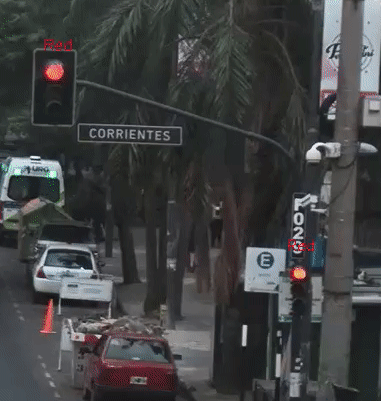

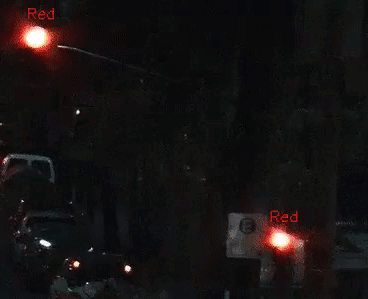

In [7]:
display(Image(filename='sample_final.gif'))
display(Image(filename='sample_night.gif'))

### Conclusions ###

Even though the light changes and movement are a hard challenge, the combination of trackers looks quite accurate, even at night, since it just tend to lose the color under sunlight (where colors becoma a mess in general) or under some rare random condition.